In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import RegularGridInterpolator

In [141]:
mua_melanin = lambda x, mvf: 519 * (x / 500) ** (-3.5) * mvf / 10  # /mm

In [142]:
df = pd.read_csv("cali_curve.csv", index_col=0)
df.set_index(["MVF", "WL"], inplace=True, drop=False)

for n, _ in df.groupby(level=0):
    # print(df.loc[(0.02, ), "Fluence"])
    df.loc[(n,), "Normalised"] = (
        df.loc[(n,), "Fluence"].values / df.loc[(0.02,), "Fluence"].values
    )

In [143]:
df["Compare Fluence"] = np.exp(-mua_melanin(df["WL"], df["MVF"]) * 0.1)
for n, _ in df.groupby(level=0):
    # print(df.loc[(0.02, ), "Fluence"])
    df.loc[(n,), "Normalised Baseline"] = (
        df.loc[(n,), "Compare Fluence"].values
        / df.loc[(0.02,), "Compare Fluence"].values
    )

# Set up an interpolation in MVF and WL

In [144]:
wavelengths = df.index.get_level_values(1)[:5].values
mvf = df.index.get_level_values(0)[::5].values

In [145]:
norm_grid = -np.log(df["Normalised"].values.reshape((-1, 5)))

correction_factor_spline = RegularGridInterpolator(
    (wavelengths, mvf), norm_grid.T, method="cubic"
)
correction_factor_spline((880, 0.02))

array(0.)

In [146]:
mvf_eval = np.linspace(0.02, 0.4 - 1e-9, 11)
wavelength_eval = np.linspace(700, 900, 11)

WL, MV = np.meshgrid(wavelength_eval, mvf_eval, indexing="ij")

interped = correction_factor_spline((WL, MV))

## Plot the correction factors

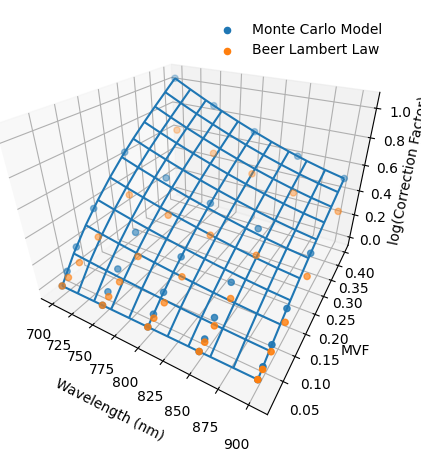

In [147]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
ax.scatter(df["WL"], df["MVF"], -np.log(df["Normalised"]), label="Monte Carlo Model")
ax.plot_wireframe(WL, MV, interped)

ax.scatter(
    df["WL"], df["MVF"], -np.log(df["Normalised Baseline"]), label="Beer Lambert Law"
)
ax.set_ylabel("MVF")
ax.set_xlabel("Wavelength (nm)")
ax.set_zlabel("log(Correction Factor)")
ax.legend(frameon=False)
ax.set_proj_type("persp", focal_length=0.2)
plt.show()